In [1]:
import pandas as pd, numpy as np, xgboost as xgb, seaborn as sns, matplotlib.pyplot as plt, warnings as wn
import re, nltk, spacy, scipy, sklearn
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist
from xgboost.sklearn import XGBClassifier
from sklearn import ensemble, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
wn.filterwarnings('ignore')
nlp = spacy.load('en')

In [2]:
df = pd.read_csv('Reviews.csv')
df.drop( ['Id','ProductId','UserId','ProfileName',
         'HelpfulnessNumerator','HelpfulnessDenominator',
         'Time', 'Summary'],axis=1,inplace=True )

df.drop_duplicates( subset=['Score','Text'],keep='first',inplace=True )  

def text_clean(text):    
    text = re.sub(r'--',' ',text)
    text = re.sub(r'<a\s+href=(?:"([^"]+)"|\'([^\']+)\').*?>(.*?)</a>',' ', text)
    text = ' '.join(text.split())
    text = text.lower()
    return text
  
df['Clean'] = df['Text'].apply( lambda x: text_clean(x) )
lemma = spacy.lang.en.English()

def lemma_text(text):
    tokens = lemma(text) 
    return( [token.lemma_ for token in tokens if not token.is_punct and not token.is_stop] )

df['lemma_text'] = df.Clean.apply(lemma_text)
X = df['Clean']
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

feature_df = pd.DataFrame()
feature_df['word_cnt'] = [ len(x.split()) for x in X_train.tolist() ]
feature_df['exclamation'] = X_train.str.findall(r'[!]').str.len()
feature_df['period'] = X_train.str.findall(r'[.]').str.len()
feature_df['question'] = X_train.str.findall(r'[?]').str.len()
feature_df['text'] = X_train
feature_df['score'] = y_train

In [7]:
vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True,
                             tokenizer=lemma_text)

X_tfidf = vectorizer.fit_transform(X)
print('Number of features:', X_tfidf.get_shape()[1])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.40, random_state=0)

svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.cumsum()
print('Percent variance of all components:', total_variance*100)

Number of features: 69650


In [9]:
tfidf_df = pd.DataFrame(data=X_train_lsa)
new_df = pd.concat( [tfidf_df, feature_df], ignore_index=False, axis=1 )
new_df = new_df.replace( [np.inf, -np.inf], np.nan ).dropna()

features = new_df.drop( ['Score','Text'], axis=1 )
predict = new_df['Score']

scalar = MinMaxScaler()
scaled = scalar.fit_transform(features)
scaled_df = pd.DataFrame(scaled)

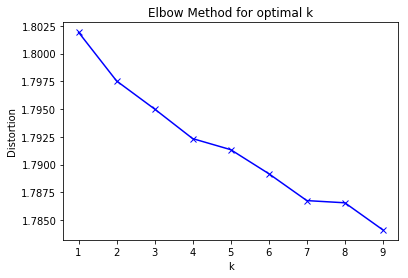

In [14]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled)
    kmeanModel.fit(scaled)
    distortions.append(sum(np.min(cdist(scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(scaled)
pd.crosstab(predict, y_pred)
print( 'Adjusted Rand Score:', adjusted_rand_score(predict, y_pred) )
print( 'Silhouette Score:' silhouette_score(scaled, y_pred, metric='euclidean') )

In [20]:
lr = LogisticRegression(class_weight = 'balanced')
train = lr.fit(scaled, predict)
lr_scores = cross_val_score(lr, scaled, predict, cv=5)
print('CV Train Scores:', lr_scores.mean() )

lr_report = classification_report(digits=6,
                                  y_true=predict, 
                                  y_pred=lr.predict(scaled))
print('Clasification report:\n', lr_report)
lr_report = confusion_matrix( y_true=predict, y_pred=lr.predict(scaled) )
print('Confusion Matrix:\n', lr_report)



Clasification report:
               precision    recall  f1-score   support

         1.0   0.238526  0.052932  0.086638     12960
         2.0   0.125858  0.058402  0.079782      7534
         3.0   0.179714  0.069388  0.100120     10852
         4.0   0.260252  0.031420  0.056071     20401
         5.0   0.650235  0.935214  0.767113     88352

   micro avg   0.607770  0.607770  0.607770    140099
   macro avg   0.290917  0.229471  0.217945    140099
weighted avg   0.490715  0.607770  0.511997    140099


Confusion Matrix:
 [[  686   434   540   264 11036]
 [  239   440   339   174  6342]
 [  303   407   753   288  9101]
 [  431   617   745   641 17967]
 [ 1217  1598  1813  1096 82628]]


In [21]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample')
train = rfc.fit(scaled, predict)
rfc_scores = cross_val_score(rfc, scaled, predict, cv=5)
print(' CV Train Scores:', rfc_scores.mean() )

rfc_report = classification_report(digits=6,
                                   y_true=predict, 
                                   y_pred=rfc.predict(scaled))

print('Clasification report:\n', rfc_report)
rfc_report = confusion_matrix(y_true=predict, y_pred=rfc.predict(scaled))
print('Confusion Matrix:\n',rfc_report)


Cross Validation Training Scores:0.60314(+/- 0.001)


In [24]:
feature_df_test = pd.DataFrame()
feature_df_test['word_cnt'] = [len(x.split()) for x in X_test.tolist()]
feature_df_test['exclamation'] = X_test.str.findall(r'[!]').str.len()
feature_df_test['period'] = X_test.str.findall(r'[.]').str.len()
feature_df_test['question'] = X_test.str.findall(r'[?]').str.len()
feature_df_test['text'] = X_test
feature_df_test['score'] = y_test

svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_test_lsa = lsa.fit_transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.cumsum()
print("Percent variance of all components:",total_variance*100)

tfidf_df_test = pd.DataFrame(data=X_test_lsa)
new_df = pd.concat( [tfidf_df_test, feature_df_test], ignore_index=False, axis=1 )
new_df = new_df.replace( [np.inf, -np.inf], np.nan ).dropna()

test_features = new_df.drop( ['Score','Text'], axis=1 )
test_predict = new_df['Score']
scalar = MinMaxScaler()
test_scaled = scalar.fit_transform(test_features)
test_df = pd.DataFrame(test_scaled)

Percent variance captured by all components: 54.64677440789001


In [27]:
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(test_scaled)
pd.crosstab(test_predict, y_pred)
print( 'Adjusted Rand Score:', adjusted_rand_score(test_predict, y_pred) )
print( 'Silhouette Score:', silhouette_score(test_scaled, y_pred, metric='euclidean'))
print( 'Logistic Regression Test Score:',lr.score(test_scaled, test_predict))

lr_report = classification_report(digits=6,
                               y_true=test_predict, 
                               y_pred=lr.predict(test_scaled))

print( 'Confusion Matrix:\n', lr_report )
print( 'Random Forest Test Score:', rfc.score(test_scaled, test_predict) )

Adjusted Rand Score: 0.00089873
Silhouette Score: -0.022522


In [30]:
rfc_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=rfc.predict(test_scaled))

print('Clasification report:\n', rfc_report)

rfc_report = confusion_matrix(y_true=test_predict, y_pred=rfc.predict(test_scaled))
print('Confusion Matrix:\n', rfc_report)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.083916  0.035591  0.049983      2023
         2.0   0.026954  0.008130  0.012492      1230
         3.0   0.054237  0.008748  0.015066      1829
         4.0   0.147271  0.044272  0.068079      3230
         5.0   0.621889  0.887356  0.731275     13627

   micro avg   0.562150  0.562150  0.562150     21939
   macro avg   0.186853  0.196819  0.175379     21939
weighted avg   0.421727  0.562150  0.470806     21939


Confusion Matrix:
 [[   72    26    24   103  1798]
 [   56    10    20    60  1084]
 [   64    29    16    92  1628]
 [  138    64    43   143  2842]
 [  528   242   192   573 12092]]
